# DASK 0. Install

대스크 설치에는 conda와 pip 2가지 방법이 있는데 pip는 에러가 생길 수 있으므로 conda로 설치하는 걸 추천합니다

conda install -y dask -> Normal 버전

conda install dask -c conda -forge  -> all common dependencis 포함 판다스 넘파이, 그리고 모든 대스크 패키지

conda install dask-core -> 대스크 모듈을 돌리기 위한 최소한으로 필요한 디펜던시 세트
(python -m pip install dask랑 비슷함)

# Dask 1. 대스크 Delayed를 사용한 병령화와 visualize, compute

Dask는 파이썬을 기반으로, Pandas를 사용하는 데이터 분석가, 엔지니어는 쉽게 사용할 수 있도록 구현되어 있으며 대량의 데이터를 다루는데 특화되어있습니다. 

In [ ]:
# 기본 함수

from time import sleep

def inc(x):
    sleep(5)
    return x + 1

def add(x, y):
    sleep(5)
    return x + y

In [ ]:
%%time

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 1.33 ms, sys: 1.32 ms, total: 2.65 ms
Wall time: 15 s


파이썬에서는 x > y > z 순으로 순차적으로 실행하기 떄문에 15초가 걸림

In [ ]:
import dask.delayed as delayed

@delayed

def inc(x):
    sleep(5)
    return x + 1


@delayed

def add(x, y):
    sleep(5)
    return x + y

Dask의 delayed 함수를 사용하기 위하여 (@)데코레이터를 사용합니다만, 파이썬과 비교를 하기 위해 기본 함수를 사용하여 비교하기를 가정합니다. 데코레이션을 사용하지 않고 사용하기 위해서는 함수 형태로 사용해주시면 됩니다.

In [ ]:
%%time

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 203 µs, sys: 203 µs, total: 406 µs
Wall time: 347 µs


z는 지연(Delayed) 객체입니다. 모든 함수에 대한 참조와 해당 입력 및 서로 간의 관계를 포함하여 최종 결과를 계산하는 데 필요한 모든 것을 갖고 있습니다.

In [ ]:
z #z가 최종 결과를 산출하는데 필요한 모든 정보를 가지고 있으며 이를 graphviz를 사용해 시각화 할 수 있습니다.

Delayed('add-78c619a0-b7cb-4923-a8bf-f4ac69bfc8ea')

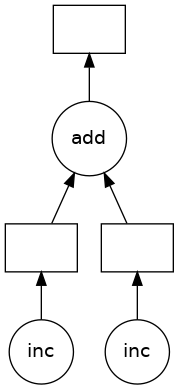

In [ ]:
z.visualize()

최종 결과를 산출하기 위해서는 compute함수를 사용합니다.

In [ ]:
%%time

z.compute()

CPU times: user 1.53 ms, sys: 5.58 ms, total: 7.11 ms
Wall time: 10 s


5

x와 y를 병렬화하여 동시 실행 후 z를 실행하기 때문에 시간은 10초가 걸렸습니다.

동시 실행을 하기 때문에 단순 비교임에도 sleep(5) 만큼의 차이를 보였습니다

# Dask 2. Delayed 함수를 사용한 For문 계산

In [ ]:
data = [1,2,3,4,5]

In [ ]:
%%time

results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
total = delayed(sum)(results)

total.compute()

CPU times: user 5.47 ms, sys: 1.4 ms, total: 6.87 ms
Wall time: 5.01 s


20

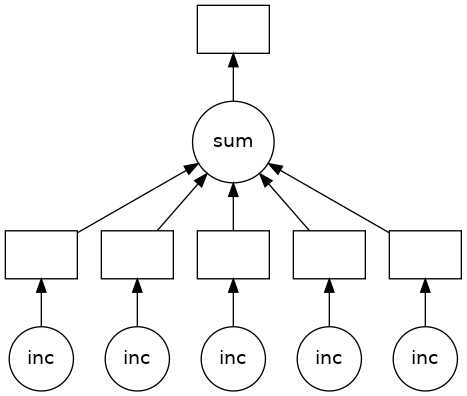

In [ ]:
total.visualize()

Delayed 연산을 통해 총 5개의 데이터 처리를 위한 for문 계산이 5초 소요되었습니다. 동시에 계산하기 때문에 sleep(5) 만큼의 시간만 소요되었습니다.

 

Dask의 delayed 함수를 사용하면 Python의 기본 연산을 조금 더 효율적으로 진행할 수 있습니다.

In [ ]:
%%time

results = []

for x in data:
    y = inc(x)
    results.append(y)
total = sum(results)

total.compute()

CPU times: user 4.44 ms, sys: 4.39 ms, total: 8.83 ms
Wall time: 5.01 s


20

# Dask 3. 대스크 Redshift 및 DB,S3,HDFS, parquet, CSV 데이터 불러오기

업무에서 사용하는 각종 DB로부터 데이터를 불러와 작업하는 방법을 알아보겠습니다.

기본적으로 Redshift에서 데이터를 불러오는 방법을 소개하나, 응용하여 다른 종류의 데이터베이스로부터 데이터를 불러올 수 있습니다.

In [ ]:
# Redshift 연결 정보
username = 'dataiger'
password = 'dataiger'
host = 'dataiger-redshift:5439'
database = 'dataiger'

connection_string = f'postgresql://{username}:{password}@{host}/{database}'
 

위의 코드처럼 데이터베이스의 정보를 입력해줍니다. 그리고 다른 종류의 데이터베이스를 사용하신다면 postgresql 부분을 변경하여 사용하시면 됩니다.

In [ ]:
# DB 데이터 불러오기
import dask.dataframe as dd

df = dd.read_sql_table(con = connection_string,
                       schema = '스키마명',
                       table_name = '테이블명',   
               	       index_col = '인덱스로 설정할 컬럼명',
                       columns = ['컬럼1', '컬럼2'], # 없으면 전체 컬럼 
                       npartitions = 10)

read_sql_table의 매개변수를 자세히 보고 싶으신 분은 아래의 링크에서 확인하시면 됩니다.

https://docs.dask.org/en/latest/generated/dask.dataframe.read_sql_table.html

아마존의 S3와 하둡 파일 시스템에서도 데이터를 쉽게 불러올 수 있습니다. S3 파일 경로와 HDFS 파일 경로를 입력해주면 쉽게 불러올 수 있습니다.

In [ ]:
# S3
s3_data = dd.read_csv('s3://bucket/path/*.csv', dtype=dtypes, usecols=usecols)

# HDFS
hdfs_data = dd.read_csv('hdfs://filepath/*.csv', dtype=dtypes, usecols=usecols)​


dtype과 usecols 매개변수는 사용하지 않아도 무방하나, 대스크는 기본적으로 데이터 타입이 중요하기 때문에 에러를 내지 않기 위해서 명시적으로 타입을 지정해줄 수 있습니다. 또한 사용할 컬럼을 명시적으로 지정하는 기능을 지원합니다.

Parquet 데이터 불러오기

대스크와 함께 parquet 파일을 사용하기 위해서는 fastparquet 또는 pyarrow 라이브러리를 설치하셔야 합니다

In [ ]:
# 라이브러리 설치 
# pip install fastparquet
# pip install pyarrow

# parquet 데이터 불러오기 
parquet_data = dd.read_parquet('*.parquet')

# S3 parquet 불러오기 
s3_parquet_data = dd.read_parquet('s3://bucket/path/*.parquet')

# HDFS parquet 불러오기 
hdfs_parquet_data = dd.read_parquet('hdfs://filepath/*.parquet')​



# Dask 3. 대스크 compute()와 persist()

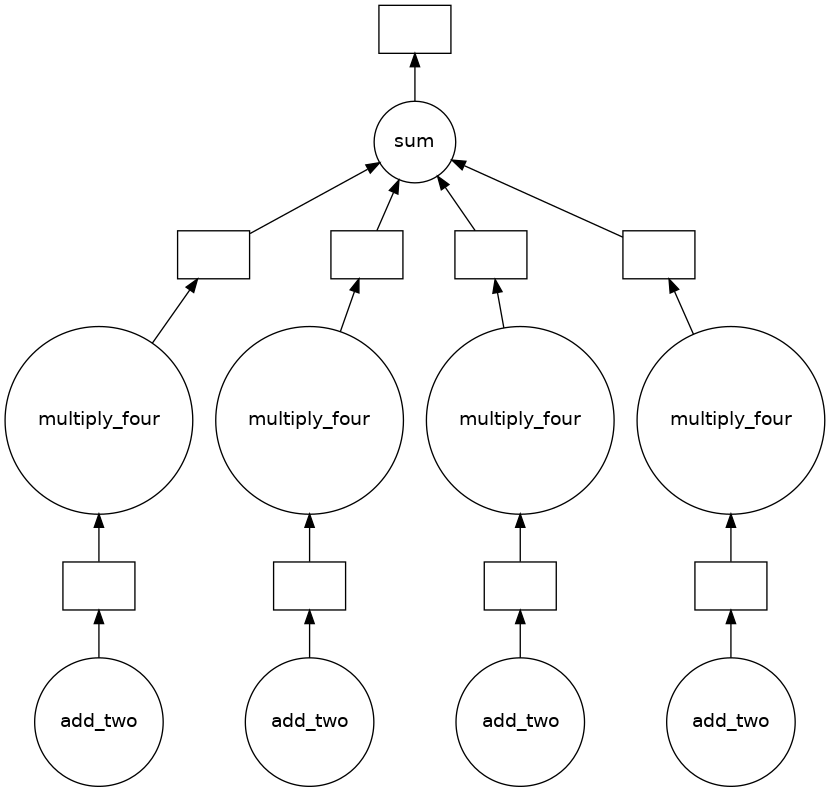

In [ ]:
import dask.delayed as delayed
from dask.diagnostics import ProgressBar

def add_two(x) :
    return x + 2

def sum_two_numbers(x, y) :
    return x + y

def multiply_four(x) :
    return x * 4

data = [1, 5, 8, 10]

step1 = [delayed(add_two)(i) for i in data]
step2 = [delayed(multiply_four)(j) for j in step1]
total = delayed(sum)(step2)
total.visualize()

단순한 덧셈 연산에 곱하기 연산을 추가한 DAG를 생성하고도 아직 단순한 것 같습니다.

위에서 생성한 DAG에 다른 계층을 추가해 보겠습니다.

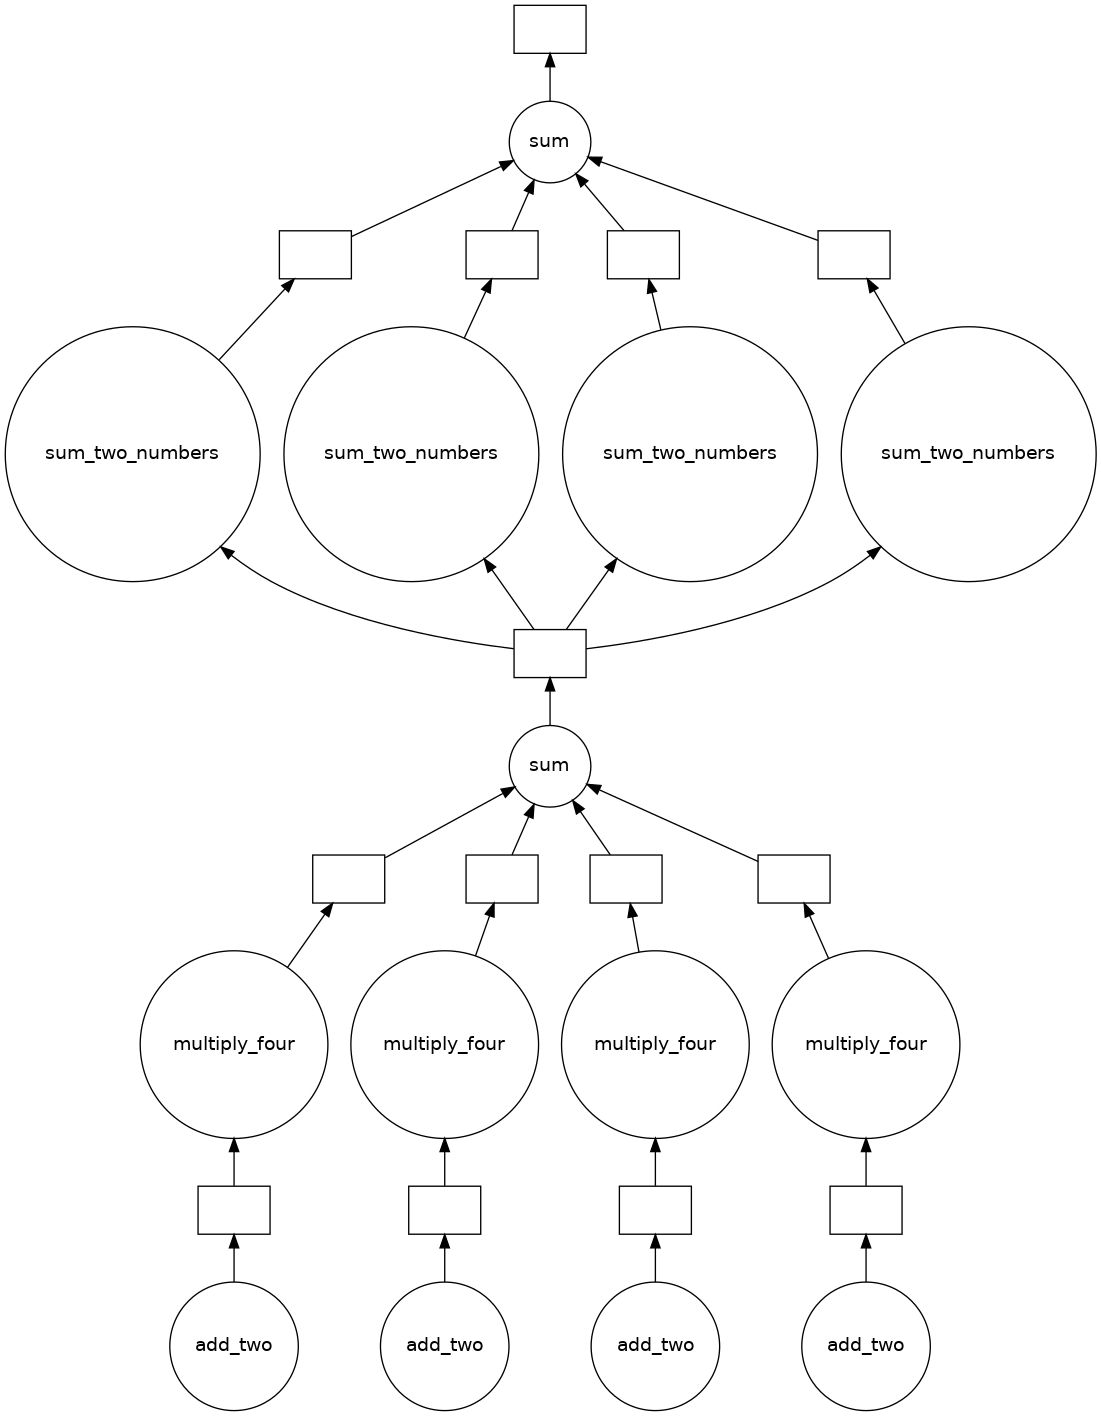

In [ ]:
data2 = [delayed(sum_two_numbers)(k, total) for k in data]
total2 = delayed(sum)(data2)
total2.visualize()

조금은 더 복잡한 DAG가 완성되었습니다.

대스크는 이러한 연산의 흐름을 생성하고 저장합니다. 다만 아직 연산이 시작된 것은 아닙니다.

이제 생성된 DAG로 compute와 persist를 비교해 보도록 하겠습니다.

 

[########################################] | 100% Completed | 106.26 ms
536


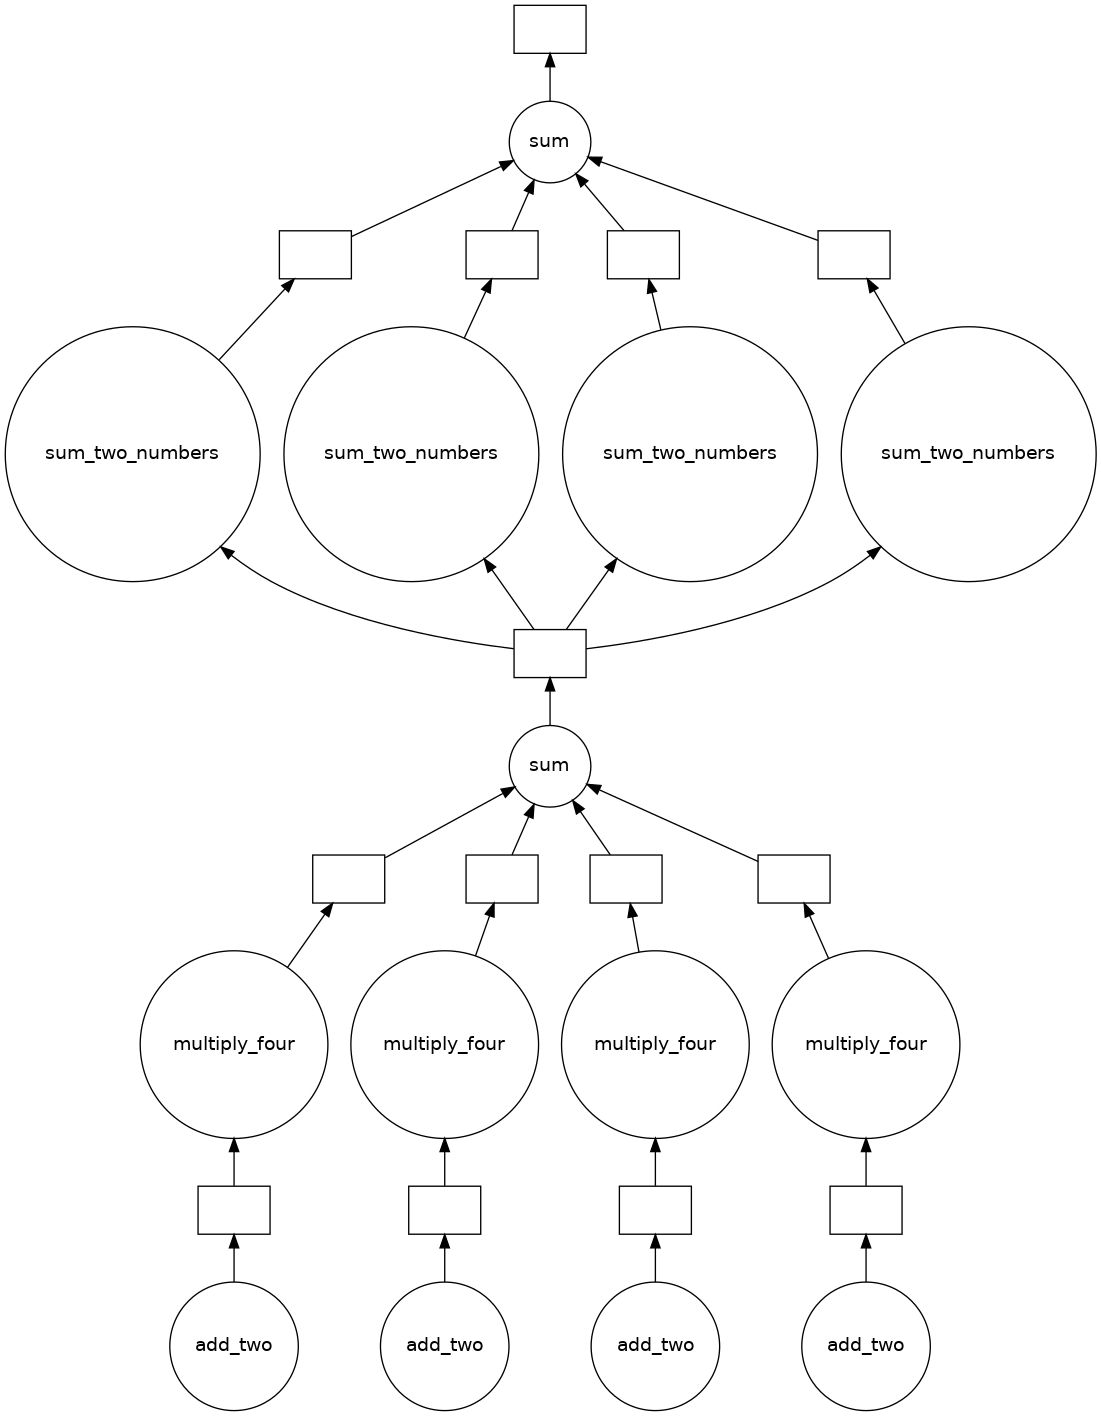

In [ ]:
#compute() vs persist()
 

#위에서 생성된 total2를 통해 compute() 메서드로 연산을 진행합니다.

 

with ProgressBar() :
    print(total2.compute())
total2.visualize()

[########################################] | 100% Completed | 104.92 ms
Delayed('sum-0027dbd9-616f-4614-8d95-9ab29e38db4c')


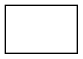

In [ ]:
with ProgressBar() :
    persisted_data = total2.persist()
    print(persisted_data)
persisted_data.visualize()

위 코드처럼 persist 메서드를 사용하면 결과를 도출하지는 않지만 지연 객체를 생성하는데, DAG가 단일 결과를 얻었습니다.

자주 사용하게 되는 연산이라면 이처럼 중간 결과를 유지하는(persist)것이 효율적일 것입니다.

 

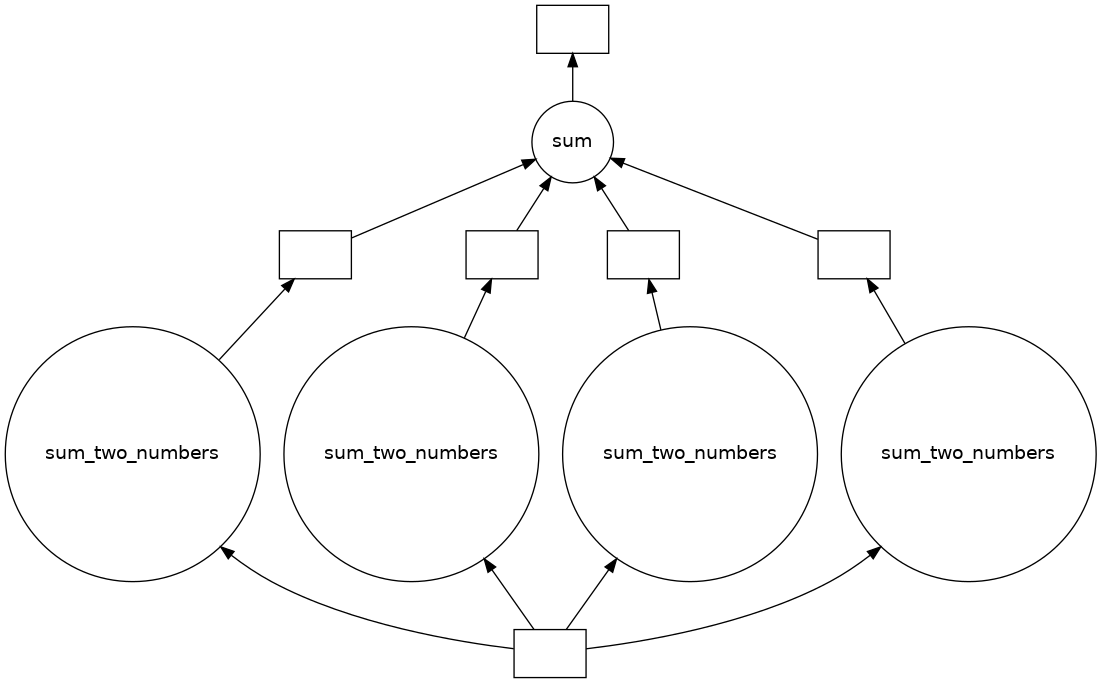

In [ ]:
data3 = [delayed(sum_two_numbers)(l, persisted_data) for l in data]
total3 = delayed(sum)(data3)
total3.visualize()

자주 사용되는 로직을 중간 저장 후에 위 코드처럼 새로운 DAG를 추가할 수 있습니다.

# Dask 4. Dataframe과 keras(기초)

In [ ]:
# 1 대스크 데이터 프레임
# 사용 데이터: NYC Flights Data(뉴욕 3개 지역 공항에서 출발하는 항공편)

In [ ]:
import urllib
import tarfile

# 뉴욕에서 출발하는 항공편 데이터 다운로드 
url = "https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz"
filename, headers = urllib.request.urlretrieve(url, '/home/aiuser/DA_4th/tony/nycflights.tar.gz')

# 압축 해제 코드
with tarfile.open(filename, mode='r:gz') as flights:
    flights.extractall('/home/aiuser/DA_4th/tony/')

api로 제공되는 데이터를 다운로드하여줍니다.

만일, 아래와 같은 에러가 난다면 SSL 코드를 실행 후 다운로드하여줍니다.

In [ ]:
# SSL 에러 발생시 해결방법
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

데이터가 준비되었다면 대스크의 데이터 프레임으로 불러오겠습니다.

In [ ]:
import dask.dataframe as dd

df = dd.read_csv('/home/aiuser/DA_4th/tony/nycflights/*.csv', parse_dates = {'Date': [0,1,2]})

NYC_flights 데이터를 확인해보면, Year, Month, DayofMonth로 날짜가 구분이 되는 것을 확인하실 수 있는데, pandas의 기능인 parse_dates = {'Date': [0, 1, 2]}을 활용하여 Date라는 새로운 컬럼에 Datatime 형식으로 불러올 수 있습니다.

대스크 데이터 프레임의 구조를 확인해보면 위의 이미지와 같이 출력이 됩니다.

npartitions : 파티션 수

int, float, object 등 : 열 데이터 유형

Dask Name : DAG 내부 이름

10 tasks : DAG 노드 수

Pandas의 데이터 프레임과는 다르게 데이터를 불러오지 않으며, 열 데이터의 유형 또한 샘플링을 통해 추정을 한 형태입니다.

 

유형에 대해 조금 더 자세히 보겠습니다

In [ ]:
df.tail()

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N54711'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.

대스크의 데이터 프레임으로 불러온 데이터에서 ValueError가 발생합니다. 이는 위에서 설명했듯이 샘플링을 통해 추정한 데이터의 타입이 실제로는 맞지 않아 발생하는 문제로, parquet 형태처럼 데이터 타입까지 같이 저장되는 형식이 아니라면 데이터 유형에 신경을 써주셔야 합니다.

 

In [ ]:
df = dd.read_csv('/home/aiuser/DA_4th/tony/nycflights/*.csv', 
                 parse_dates = {'Date': [0, 1, 2]},
                 dtype={'CRSElapsedTime': 'float64',
                        'TailNum': 'object'}   
                )

In [ ]:
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


위에서 데이터 프레임에 대해 가볍게 살펴보았습니다.

Dask의 장점은 Pandas와 동일하게 여러 ML 라이브러리와 연동하여 사용할 수 있는 점입니다.

지금은 아주 간단한 Keras 모델링을 해보도록 하겠습니다.

 

In [ ]:
df_train = df[['CRSDepTime',  'CRSArrTime', 'Cancelled']]

위에서 불러온 df에서 출발과 도착시간을 통해 취소여부에 대해 예측하는 모델을 만들어 보겠습니다.



In [ ]:
with ProgressBar() : 
    print(df_train.isnull().sum().compute())

[########################################] | 100% Completed | 4.04 ss
CRSDepTime    0
CRSArrTime    0
Cancelled     0
dtype: int64


총 269,180행의 데이터의 Null 값 여부가 4초 만에 계산되었고, 따로 전처리를 하지 않아도 될 것 같습니다.

모델을 만들어 학습까지 진행해보도록 하겠습니다.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
# input_dim=df_train.iloc[:, :-1] : Cancelled 컬럼을 제외한 dimension 
model.add(Dense(20, input_dim=df_train.iloc[:, :-1].shape[1], activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='sgd',)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
# input_dim=df_train.iloc[:, :-1] : Cancelled 컬럼을 제외한 dimension 
model.add(Dense(20, input_dim=df_train.iloc[:, :-1].shape[1], activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='sgd',)

2022-10-08 21:35:56.171472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-08 21:35:56.315293: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-08 21:35:56.321385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-08 21:35:56.321398: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [ ]:
model.fit(df_train.iloc[:, :-1].compute(), df_train.iloc[:, -1].compute(),
          batch_size=256,
          epochs=10
         )

Epoch 1/10
10203/10203 [==============================] - 12s 1ms/step - loss: 1.6561
Epoch 2/10
10203/10203 [==============================] - 11s 1ms/step - loss: 0.1247
Epoch 3/10
10203/10203 [==============================] - 11s 1ms/step - loss: 0.1247
Epoch 4/10
10203/10203 [==============================] - 11s 1ms/step - loss: 0.1247
Epoch 5/10
10203/10203 [==============================] - 11s 1ms/step - loss: 0.1247
Epoch 6/10
10203/10203 [==============================] - 11s 1ms/step - loss: 0.1247
Epoch 7/10
10203/10203 [==============================] - 10s 1ms/step - loss: 0.1247
Epoch 8/10
10203/10203 [==============================] - 9s 919us/step - loss: 0.1247
Epoch 9/10
10203/10203 [==============================] - 11s 1ms/step - loss: 0.1247
Epoch 10/10
10203/10203 [==============================] - 11s 1ms/step - loss: 0.1247


빅데이터를 사용할 때에는 generator와 compute()를 사용하여 validation을 적용하여 사용하면 됩니다.

# 참고자료

https://mindscale.kr/course/python-ds/5/


https://dataiger.tistory.com/4?category=1088132